## Previsao de Embarque 
- Simples 
- Sem Serie Temporal
- Regressao Linear
- Random Forest
- Com Grid Search
- Bagging, Stacking e Boosting

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
import datetime as dt

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from pprint import pprint
from math import sqrt

from variables import day_of_week_translator, feriados, vesperas

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')

## Filtro de Onibus e definicoes de features/target

In [30]:
# Reading Data file (geolocalized)
data = pd.read_csv('../data_input_zerofill_2015.csv', delimiter=";")

busline_filter = 41
data_model = data.copy()

#d_ano,  estao disponiveis para inserir once eu tive mais de 1 ano de dados
feature_names = [
    'hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado']

target = 'validations_per_hour'

In [31]:
data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes
0,1,2015-01-15 02:00:00,0,3,0.519584,0.854419,2,15,15,1,3
1,1,2015-01-25 02:00:00,0,6,0.519584,0.854419,2,25,25,1,4
2,1,2015-01-25 06:00:00,0,6,0.997669,-0.068242,6,25,25,1,4
3,1,2015-01-25 07:00:00,0,6,0.942261,-0.334880,7,25,25,1,4
4,1,2015-01-25 08:00:00,0,6,0.816970,-0.576680,8,25,25,1,4
...,...,...,...,...,...,...,...,...,...,...,...
2081985,999,2015-12-05 09:00:00,18,5,0.631088,-0.775711,9,5,339,12,0
2081986,999,2015-12-05 10:00:00,64,5,0.398401,-0.917211,10,5,339,12,0
2081987,999,2015-12-05 11:00:00,8,5,0.136167,-0.990686,11,5,339,12,0
2081988,999,2015-12-05 12:00:00,43,5,-0.136167,-0.990686,12,5,339,12,0


In [32]:
one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]

top100_linhas = data_model.linha.value_counts().index[:100]
top100_linhas_data_model = data_model[data_model.linha.isin(top100_linhas)].loc[data['mes'] != 8]

top100_linhas_data_model.to_csv("../dados-para-modelos/2015/top100_linhas_data_model_2015.csv", index=False)
sns.set(rc={'figure.figsize':(15,10)})

# sns.heatmap(top100_linhas_data_model.corr()[['validations_per_hour']].sort_values(by='validations_per_hour', ascending=False)
# , vmin=-1, vmax=1, annot=True)

line_data_model = data_model.loc[data['linha'] == busline_filter].loc[data['mes'] != 8].copy()

In [33]:
top100_linhas_data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
0,1,2015-01-15 02:00:00,0,3,5.195840e-01,0.854419,2,15,15,1,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
1,1,2015-01-25 02:00:00,0,6,5.195840e-01,0.854419,2,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2,1,2015-01-25 06:00:00,0,6,9.976688e-01,-0.068242,6,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,1,2015-01-25 07:00:00,0,6,9.422609e-01,-0.334880,7,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
4,1,2015-01-25 08:00:00,0,6,8.169699e-01,-0.576680,8,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080785,920,2015-12-31 19:00:00,234,3,-8.878852e-01,0.460065,19,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
2080786,920,2015-12-31 20:00:00,240,3,-7.308360e-01,0.682553,20,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
2080787,920,2015-12-31 21:00:00,222,3,-5.195840e-01,0.854419,21,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
2080788,920,2015-12-31 22:00:00,147,3,-2.697968e-01,0.962917,22,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [34]:
#display(X)

In [35]:
#display(y)

---------------------------------------------------------------------------- Fim Setup ----------------------------------------------------------------------------  
# Criacao dos Modelos

In [36]:
# Per Line Data

X = line_data_model.filter(feature_names, axis=1)
y = line_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [37]:
model_list = []

In [38]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict) * 100
    performance_scoring = [
        r2,
        rmse,
        mae,
        mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

In [39]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()

#### Linear Regression Model Parameters

In [40]:
# print("Linear Regression  Params ----> ")
# pprint(LinearRegressionModel.get_params())

copy_X = [True, False]
fit_intercept = [True, False]
n_jobs = [2, 4, 6, 8]
normalize = [True, False]

# Create the random grid
random_grid_linearregression = {'copy_X': copy_X, 'fit_intercept': fit_intercept, 'n_jobs': n_jobs, 'normalize': normalize}

#### Random Forest Model Parameters

In [41]:
# print("Random Forest Model Params ----> ")
# pprint(RandomForestModel.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 10)]

n_jobs = [2, 4, 6, 8]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs': n_jobs}

# Grid Searched

In [42]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()
gridsearch_result_randomforest = RandomizedSearchCV(estimator = RandomForestModel, param_distributions = random_grid_randomforest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gridsearch_result_linearregression = RandomizedSearchCV(estimator = LinearRegressionModel, param_distributions = random_grid_linearregression, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model

gridsearch_result_randomforest.fit(X_train, Y_train)
gridsearch_result_linearregression.fit(X_train, Y_train)

print("Random Forest Best Parameters -----> ")
pprint(gridsearch_result_randomforest.best_params_)

print("Linear Regression Best Parameters -----> ")
pprint(gridsearch_result_linearregression.best_params_)

gridsearched_random_randomforest = gridsearch_result_randomforest.best_estimator_
gridsearched_random_linearregression = gridsearch_result_linearregression.best_estimator_

default_linearregression_model = LinearRegressionModel.fit(X_train, Y_train)
default_randomforest_model = RandomForestModel.fit(X_train, Y_train)

GridSearchedRandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)
DefaultRandomForestModelPipeline = make_pipeline(default_randomforest_model)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Random Forest Best Parameters -----> 
{'bootstrap': False,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 455,
 'n_jobs': 2}
Linear Regression Best Parameters -----> 
{'copy_X': True, 'fit_intercept': False, 'n_jobs': 2, 'normalize': True}


In [43]:
performance_default_randomforest_model = get_performance(default_randomforest_model)
performance_gridsearched_randomforest_model = get_performance(gridsearched_random_randomforest)
performance_gridsearched_linearregression_model = get_performance(gridsearched_random_linearregression)
performance_default_linearregression_model = get_performance(default_linearregression_model)

print("\n----------------------------------------------------\n")
print('Regressao Linear [DEFAULT]: \n', performance_default_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [DEFAULT]: \n', performance_default_randomforest_model)
print("\n----------------------------------------------------\n")
print('Regressao Linear [GRID SEARCH]: \n', performance_gridsearched_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [GRID SEARCH]: \n', performance_gridsearched_randomforest_model)
print("\n----------------------------------------------------\n")

performance_total = [performance_default_linearregression_model,
    performance_default_randomforest_model,
    performance_gridsearched_linearregression_model,
    performance_gridsearched_randomforest_model]

performance_total = pd.DataFrame.from_records(performance_total, columns=['R2', 'RMSE', 'MAE', 'MAPE'], 
    index=['LinearReg Default', 'RandomForest Default', 'LinearReg GridSearched', 'RandomForest GridSearched'])
performance_total


----------------------------------------------------

Regressao Linear [DEFAULT]: 
 [0.436572871539908, 326.0775002848704, 251.35267177600483, 1.4307770373080023e+19]

----------------------------------------------------

Random Forest [DEFAULT]: 
 [0.9130915426299729, 128.06574393049175, 67.5746197821696, 4.775104326659622e+18]

----------------------------------------------------

Regressao Linear [GRID SEARCH]: 
 [0.436572871539909, 326.07750028487015, 251.35267177600142, 1.4307770373079427e+19]

----------------------------------------------------

Random Forest [GRID SEARCH]: 
 [0.9286137216440059, 116.0671516022776, 71.43918304462755, 4.0434424847486147e+18]

----------------------------------------------------



,R2,RMSE,MAE,MAPE
LinearReg Default,0.436573,326.077500,251.352672,1.430777e+19
RandomForest Default,0.913092,128.065744,67.574620,4.775104e+18
LinearReg GridSearched,0.436573,326.077500,251.352672,1.430777e+19
RandomForest GridSearched,0.928614,116.067152,71.439183,4.043442e+18


# BAGGING

In [44]:
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run
models_scores = [] # To store model scores               

def bagging_model(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, Y_train)

    br_y_pred = regr.predict(X_test)

    performance = get_performance(regr)
    
    print(f'Performance for base estimator {regr.base_estimator_} = {performance}\n')

    return regr, performance

LinearRegressionModelPipeline = make_pipeline(LinearRegression())
RandomForestModelPipeline = make_pipeline(RandomForestRegressor())


bagging_lr_model, performance_bagging_lr_model = bagging_model(LinearRegressionModelPipeline)
bagging_rf_model, performance_bagging_rf_model = bagging_model(RandomForestModelPipeline)

df2 = pd.DataFrame([performance_bagging_lr_model, performance_bagging_rf_model], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['LinearRegression Bagging', 'RandomForest Bagging'])
performance_total = pd.concat([df2, performance_total])

BaggingLinearRegressionModelPipeline = make_pipeline(bagging_lr_model)
BaggingRandomForestModelPipeline = make_pipeline(bagging_rf_model)


Performance for base estimator Pipeline(steps=[('linearregression', LinearRegression())]) = [0.4358762931081954, 326.27900672772085, 252.22924429812392, 1.444632288850111e+19]

Performance for base estimator Pipeline(steps=[('randomforestregressor', RandomForestRegressor())]) = [0.9062632693581588, 133.00159740950357, 69.30567811629938, 5.2575900895704e+18]



# BOOSTING

In [45]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

gradient_boosting_regressor.fit(X_train, Y_train)

performance = get_performance(gradient_boosting_regressor)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['GradientBoostingRegressor'])

GradientBoostingModelPipeline = make_pipeline(gradient_boosting_regressor)

performance_total = pd.concat([df2, performance_total])


# STACKING

In [46]:
estimators = [
    ('gridseached_randomforest', GridSearchedRandomForestModelPipeline),
    ('bagging_randomforest',BaggingRandomForestModelPipeline),
    ('gradient_boosting', GradientBoostingModelPipeline), 
    ('random_forest_default', DefaultRandomForestModelPipeline)
]

stack = StackingRegressor(estimators=estimators, final_estimator=DefaultRandomForestModelPipeline, cv= 5, n_jobs= n_jobs, passthrough = True)

stack.fit(X_train, Y_train)

performance = get_performance(stack)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Stacking Regressors'])

performance_total = pd.concat([df2, performance_total])

In [ ]:
# model_list = [
#     stack,
#     gradient_boosting_regressor,
#     bagging_rf_model,
#     default_randomforest_model,
#     #default_linearregression_model,
#     #gridsearched_result_linearregression,
#     #gridsearched_random_randomforest,
#     #bagging_lr_model,
# ]

sample = X.sample(n=1)
sample

print('LINHA UTILIZADA PARA OS TESTES: ', busline_filter)

print("\nUtilizando sample aleatorio de dado para teste de previsao: ")

display(data_model.loc[sample.index[0]:sample.index[0]])

res = stack.predict(sample)
print("Stacked Regressor -> resultado do predict de test: ", res)

res = gradient_boosting_regressor.predict(sample)
print("gradient_boosting_regressor -> resultado do predict de test: ", res)

res = bagging_rf_model.predict(sample)
print("bagging_rf_model -> resultado do predict de test: ", res)

res = gridsearched_random_randomforest.predict(sample)
print("Random Forest Best Grid Searched -> resultado do predict de test: ", res)

res = default_randomforest_model.predict(sample)
print("Random Forest Default -> resultado do predict de test: ", res)

res = bagging_lr_model.predict(sample)
print("bagging_lr_model -> resultado do predict de test: ", res)

res = default_linearregression_model.predict(sample)
print("Regressao Linear Default -> resultado do predict de test: ", res)

res = gridsearched_random_linearregression.predict(sample)
print("Regressao Linear Best Grid Searched -> resultado do predict de test: ", res)

LINHA UTILIZADA PARA OS TESTES:  41

Utilizando sample aleatorio de dado para teste de previsao: 


,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
231612,41,2015-12-23 01:00:00,0,2,0.269797,0.962917,1,23,357,12,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


Stacked Regressor -> resultado do predict de test:  [0.]
gradient_boosting_regressor -> resultado do predict de test:  [21.08956237]
bagging_rf_model -> resultado do predict de test:  [0.]
Random Forest Best Grid Searched -> resultado do predict de test:  [0.]
Random Forest Default -> resultado do predict de test:  [0.]
bagging_lr_model -> resultado do predict de test:  [286.71349482]
Regressao Linear Default -> resultado do predict de test:  [282.18490188]
Regressao Linear Best Grid Searched -> resultado do predict de test:  [282.18490188]


In [ ]:
#performance_total.to_csv('../performances/2015/performance_total_linha'+str(busline_filter)+'.csv', index=False)

In [ ]:
performance_total.sort_values('MAE', ascending=True)

,R2,RMSE,MAE,MAPE
Stacking Regressors,0.969980,75.267178,46.876932,1.161348e+18
GradientBoostingRegressor,0.951662,95.509346,59.197949,4.590700e+18
RandomForest Default,0.912492,128.506787,68.087513,4.848482e+18
RandomForest Bagging,0.906263,133.001597,69.305678,5.257590e+18
RandomForest GridSearched,0.928788,115.925096,71.528854,4.059628e+18
LinearReg GridSearched,0.436573,326.077500,251.352672,1.430777e+19
LinearReg Default,0.436573,326.077500,251.352672,1.430777e+19
LinearRegression Bagging,0.435876,326.279007,252.229244,1.444632e+19


### Todos os modelos treinados dentro de *model_list*

In [ ]:
model_list = [
    stack,
    gradient_boosting_regressor,
    bagging_rf_model,
    default_randomforest_model,
    gridsearch_result_randomforest,
    #default_linearregression_model,
    #gridsearch_result_linearregression,
    #bagging_lr_model,
]

## Treinar com 1 mes, prever N semanas

In [ ]:
# Jan, Fev, Mar, Abril, Maio
# treina com mar, preve 2 semanas de abril

mes_de_treino = 3
mes_de_previsao = 4

line_mes_data_model = line_data_model[line_data_model.mes == mes_de_treino]

line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

df_prev = line_mes_data_model_predict[line_mes_data_model_predict.semana_do_mes <  2].filter(feature_names, axis = 1)
real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.semana_do_mes <  2].validations_per_hour)

X = line_mes_data_model.filter(feature_names, axis=1)
y = line_mes_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

predictions = [[],[],[],[],[]]
performances = list()

for i, model in enumerate(model_list):
        model.fit(X_train, Y_train)
        performances.append(get_performance(model))

        for index, row in df_prev.iterrows():
            predictions[i].append(model.predict([row])[0])


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
df_performance = pd.DataFrame(performances)
df_performance.to_csv('../performances/2015/linha'+str(busline_filter)+'_1mes('+str(mes_de_treino)+')_1semanas('+str(mes_de_previsao)+')_performance.csv', index=False)
df_predict_dados = real_values
df_predict_dados['validations_per_hour_predicted'] = predictions[0]

df_predict_dados.to_csv('../predict-vs-real/2015/linha'+str(busline_filter)+'_1mes('+str(mes_de_treino)+')_1semanas('+str(mes_de_previsao)+')_predict.csv', index=False)
df_predict_dados

,validations_per_hour,validations_per_hour_predicted
230684,0,0.9500
230685,0,0.2900
230686,0,3.7000
230687,0,0.2900
230688,0,0.2900
...,...,...
233770,452,621.2400
233771,436,519.0900
233772,320,380.9900
233773,136,229.1100


### Treinar com (N-Y) meses, Prever mes (N)

In [ ]:
predictions = []
performances = [[],[],[],[],[],[],[],[]]

df_treinamento = line_data_model[line_data_model.mes < 6].copy()
df_previsao = line_data_model[line_data_model.mes == 6].loc[line_data_model.d_mes < 8].copy()
df_prev = df_previsao.filter(feature_names, axis = 1)
df_results = df_previsao.filter('validations_per_hour', axis = 1)

print(df_results.__len__())

X = df_treinamento.filter(feature_names, axis=1)
y = df_treinamento.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)


stack.fit(X_train, Y_train)
# performances[i].append(get_performance(stack))

for index, row in df_prev.iterrows():
    predictions.append(stack.predict([row])[0])

df_results = df_previsao.validations_per_hour

df_performance = pd.DataFrame(performances)
df_performance.to_csv('../performances/2020/performance_9_meses_predict_10th_stacking.csv', index=False)




168


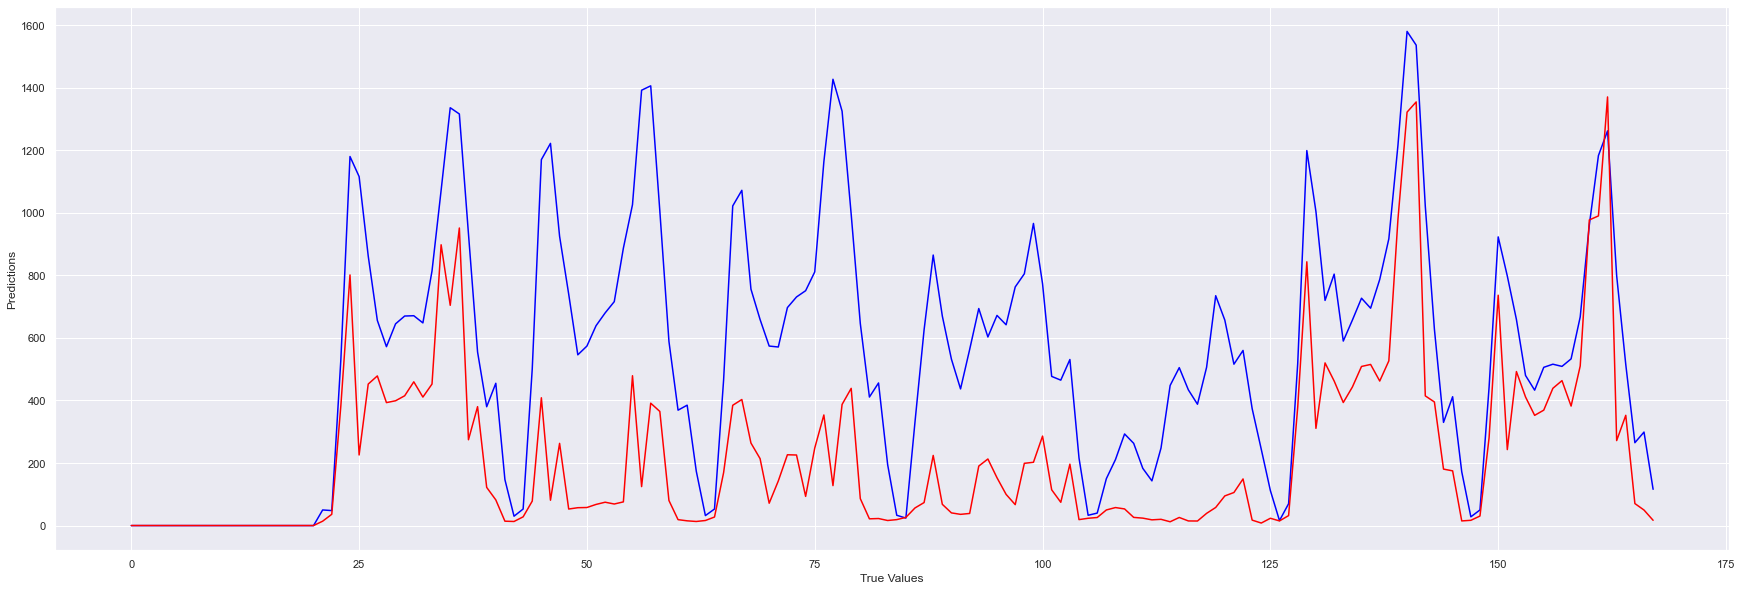

In [ ]:
# 168 == quantidade de horas previstas em 1 semana
plt_size = 168

plt.figure(figsize=(30, 10))
plt.plot(range(df_results.size), df_results.values, color='blue')
plt.plot(range(predictions.__len__()), predictions, color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
performances

## Ranking Linhas de Onibus

In [29]:

# print(data_model.linha.value_counts(ascending=True)[data_model['linha'].value_counts() < 100])

# linha_lista = data_model.linha.unique()
# linha_lista = linha_lista[:10]
res_map = list()
top100_linhas = data_model.linha.value_counts().index[:100]

for linha in top100_linhas:
    currentLinhaData = top100_linhas_data_model.loc[top100_linhas_data_model['linha'] == linha].copy()
    X = currentLinhaData.filter(feature_names, axis=1)
    y = currentLinhaData.validations_per_hour
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
    for model in model_list:
        model.fit(X_train, Y_train)
        performance = get_performance(model)
        performance.insert(0, linha)
        res_map.append(performance)
res_map = pd.DataFrame(res_map, columns=["Linha", "R2", "RMSE", "MAE", 'MAPE'])
r = res_map.sort_values('MAE', ascending=True)
r.to_csv("../performances/2015/ranking_top100_2015.csv", index=False)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 3

In [ ]:
# res_map = pd.DataFrame(res_map,columns=['Linha', 
#     # '[LR][DEF]R2', '[LR][DF]RMSE', '[LR][DF]MAE',
#     '[RF][GS]R2', '[RF][GS]RMSE', '[RF][GS]MAE',
#     # '[LR][BAG]R2', '[LR][BAG]RMSE', '[LR][BAG]MAE',
#     '[RF][BAG]R2', '[RF][BAG]RMSE', '[RF][BAG]MAE',
#     '[STK]R2', '[STK]RMSE', '[STK]MAE',
#     # '[BOS]R2', '[BOS]RMSE', '[BOS]MAE' 
#     ])
res_map = pd.DataFrame(res_map,columns=['Linha','R2', 'RMSE', 'MAE', 'MAPE'])

#performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
res_map = res_map.sort_values('MAE', ascending=True).reset_index(drop=True)
res_map = res_map.drop_duplicates(subset='Linha', keep="first").reset_index(drop=True)
res_map.to_csv('../top100linhas_rank_2015.csv', index=False)
res_map